# Matchup JSON output for COVERAGE Demo

This Notebook will demonstrate the CAML output capability of SDAP's `/matchup_spark` endpoint.

## Preparation

You will need a running instance of SDAP. It can be either on your local machine or available through a public API (ie, CDMS).

If you wish to run it locally, start it now and run the following cell.

In [1]:
HOST = 'http://localhost:8083/'

If the capability has been deployed to a publicly exposed SDAP instance, set the `HOST` to point to that instance.

The next cell will be using CDMS, you should edit it if you're using something different.

DO NOT run this cell if you are using a local instance.

In [ ]:
HOST = 'http://doms.jpl.nasa.gov/'

## Execute matchup query

This section will set up and run the matchup query.

In [2]:
import json
import re
from urllib.parse import urljoin

import matplotlib.dates as md
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import requests
from dateutil import parser
from matplotlib.lines import Line2D
from mpl_toolkits.basemap import Basemap

In [3]:
url = urljoin(HOST, 'match_spark')

params = {
        "primary": "MUR25-JPL-L4-GLOB-v04.2",
        "startTime": "2017-07-01T00:00:00Z",
        "endTime": "2017-07-03T23:59:59Z",
        "tt": 3600,
        "rt": 25000,
        "b": "-100,20,-79,30",
        "depthMin": -10,
        "depthMax": 10,
        "matchOnce": True,
        "secondary": "ICOADS Release 3.0",
        "resultSizeLimit": 7000,
        "platforms": "0,16,17,30,41,42",
        "parameter": "sea_water_temperature",
        "output": "CAML",
        "camlPrimary": "sea_surface_foundation_temperature",
        "camlSecondary": "sea_water_temperature",
        "camlChartTypes": "time_series,scatter,histogram_primary,histogram_secondary,trajectory" # comment this line out to disable 
                                                                                                 #time series output
    }

params_shark = {
        "primary": "MUR25-JPL-L4-GLOB-v04.2",
        "startTime": "2018-04-02T0:00:00Z",
        "endTime": "2018-04-05T0:00:00Z",
        "tt": 3600,
        "rt": 25000,
        "b": "-140,10,-110,40",
        "depthMin": -10,
        "depthMax": 10,
        "matchOnce": True,
        "secondary": "shark-2018",
        "resultSizeLimit": 7000,
        "platforms": "3B",
        "parameter": "sea_water_temperature",
        "output": "CAML",
        "camlPrimary": "sea_surface_foundation_temperature",
        "camlSecondary": "sea_water_temperature",
        "camlChartTypes": "time_series,scatter,histogram_primary,histogram_secondary,trajectory" # comment this line out to disable 
                                                                                                 #time series output
    }

print('Running matchup query. This may take a few minutes...', end='')

# Regular query - can sometimes fail when IS data is being ingested
#response = requests.get(url, params=params)
# Alternate query - uses a different IS endpoint
response = requests.get(url, params=params_shark)

print('done')

assert response.ok

caml = response.json()

print(json.dumps(caml, indent=4))

Running matchup query. This may take a few minutes...done
{
    "query": {
        "apiRequest": "http://localhost:8083/match_spark?primary=MUR25-JPL-L4-GLOB-v04.2&startTime=2018-04-02T0%3A00%3A00Z&endTime=2018-04-05T0%3A00%3A00Z&tt=3600&rt=25000&b=-140%2C10%2C-110%2C40&depthMin=-10&depthMax=10&matchOnce=True&secondary=shark-2018&resultSizeLimit=7000&platforms=3B&parameter=sea_water_temperature&output=CAML&camlPrimary=sea_surface_foundation_temperature&camlSecondary=sea_water_temperature&camlChartTypes=time_series%2Cscatter%2Chistogram_primary%2Chistogram_secondary%2Ctrajectory",
        "analysisName": "colocation_trajectory",
        "primaryName": "MUR25-JPL-L4-GLOB-v04.2",
        "secondaryName": "shark-2018",
        "bounds": {
            "lon_min": -140.0,
            "lon_max": -110.0,
            "lat_min": 10.0,
            "lat_max": 40.0,
            "time_start": "2018-04-02T00:00:00+00:00+0000",
            "time_end": "2018-04-05T00:00:00+00:00+0000"
        }
    },
 

### NOTE

If the above query fails, use this cell to load a local example of CAML output.

In [5]:
file = 'saved.json'

caml = json.load(open(file))

# print(json.dumps(caml, indent=4))

## Time-series plot

(array([17348. , 17348.5, 17349. , 17349.5, 17350. , 17350.5, 17351. ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

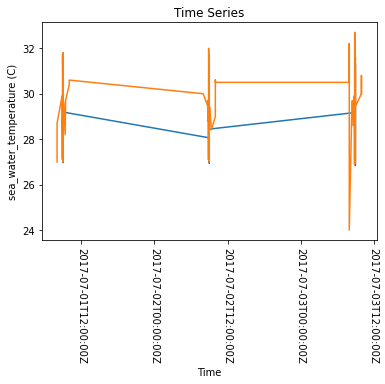

In [6]:
data = caml['result']['chart']
points_p = data['xySeries_data'][0]
points_s = data['xySeries_data'][1]

points_p.sort(key=lambda e: e[0])
points_s.sort(key=lambda e: e[0])

fig, ax = plt.subplots()
ax.set_title(data['title'])
ax.set_xlabel(data['xAxis_label'])
ax.set_ylabel(data['yAxis_label'])

xfmt = md.DateFormatter('%Y-%m-%dT%H:%M:%SZ')
ax.xaxis.set_major_formatter(xfmt)

def convert(points):
    dates = [parser.parse(p[0][0:19] + 'Z') for p in points]
    datenums=md.date2num(dates)
    return datenums

ax.plot(convert(points_p), [p[1] for p in points_p])
ax.plot(convert(points_s), [p[1] for p in points_s])

plt.xticks( rotation=-90 )

## Scatter plot

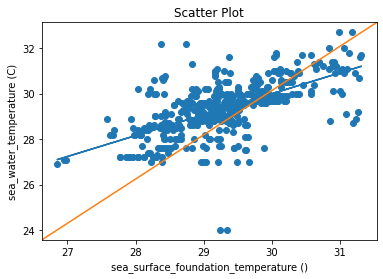

In [7]:
data = caml['result']['chart_1']

primary_points = np.array([point[0] for point in data['xySeries_data']])
secondary_points = np.array([point[1] for point in data['xySeries_data']])

m,b = np.polyfit(primary_points, secondary_points, 1)
fig, ax = plt.subplots()
ax.set_title(data['title'])
ax.set_xlabel(data['xAxis_label'])
ax.set_ylabel(data['yAxis_label'])
ax.scatter(primary_points, secondary_points)
ax.plot(primary_points, m*primary_points+b)
ax.plot([0,1],[0,1], transform=ax.transAxes)

## Histogram: Primary

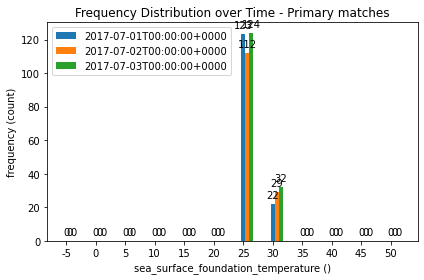

In [8]:
data = caml['result']['chart_2']

bins = [-5, 0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]

x = np.arange(len(bins))
width = .4

fig, ax = plt.subplots()

rects = []

counts = data['xySeries_data'][1:]

f_width = width/len(counts)

for i in range(len(counts)):
    rects.append(ax.bar(x+i*f_width, [c[1] for c in counts[i][0][1:]], f_width, label=counts[i][0][0]))
    
ax.set_title(data['title'] + " - Primary matches")
ax.set_xlabel(data['xAxis_label'])
ax.set_ylabel(data['yAxis_label'])
ax.set_xticks(x)
ax.set_xticklabels([str(b) for b in bins])
ax.legend()

for r in rects:
    ax.bar_label(r, padding=4)

fig.tight_layout()

plt.show()

## Histogram: Secondary

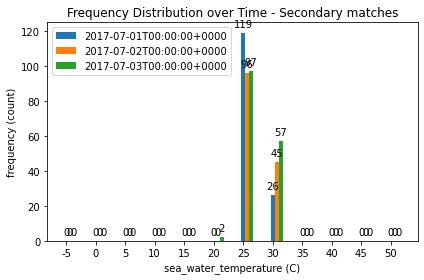

In [9]:
data = caml['result']['chart_3']

bins = [-5, 0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]

x = np.arange(len(bins))
width = 0.4

fig, ax = plt.subplots()

rects = []

counts = data['xySeries_data'][1:]

f_width = width/len(counts)

for i in range(len(counts)):
    rects.append(ax.bar(x+i*f_width, [c[1] for c in counts[i][0][1:]], f_width, label=counts[i][0][0]))
    
ax.set_title(data['title'] + " - Secondary matches")
ax.set_xlabel(data['xAxis_label'])
ax.set_ylabel(data['yAxis_label'])
ax.set_xticks(x)
ax.set_xticklabels([str(b) for b in bins])
ax.legend()

for r in rects:
    ax.bar_label(r, padding=4)

fig.tight_layout()

plt.show()

## Difference Map

['sea_water_temperature (C)']


Text(0.5, 1.0, 'Along track colocation differences')

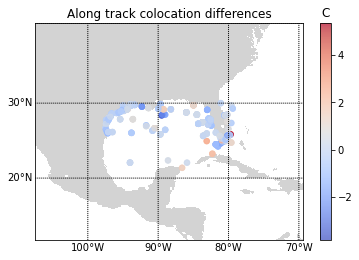

In [10]:
data = caml['result']['map']

points = data['xySeries_data']

if False: # Correct code doesn't work due to bug; unwrap when fixed
    min_lat = min([p[1][0] for p in points])
    max_lat = max([p[1][0] for p in points])
    min_lon = min([p[1][1] for p in points])
    max_lon = max([p[1][1] for p in points])
else:
    min_lat = min([float(p[1][0]) for p in points])
    max_lat = max([float(p[1][0]) for p in points])
    min_lon = min([float(p[1][1]) for p in points])
    max_lon = max([float(p[1][1]) for p in points])

basemap = Basemap(
    projection='mill',
    lon_0=180,
    llcrnrlat=min_lat - 10,
    urcrnrlat=max_lat + 10,
    llcrnrlon=min_lon - 10,
    urcrnrlon=max_lon + 10
)
basemap.drawlsmask(
        land_color='lightgrey',
        ocean_color='white',
        lakes=True
    )

basemap.drawparallels(np.arange(-90.,91.,10.), labels=[True, False, False, True])
basemap.drawmeridians(np.arange(-180.,181.,10.), labels=[True, False, False, True])

x,y = basemap([float(p[1][1]) for p in points], [float(p[1][0]) for p in points])

cmap = plt.cm.coolwarm

sc = plt.scatter(x,y,30,marker='o',c=[p[2] for p in points], alpha=0.7, cmap=cmap)

cb = plt.colorbar(sc)

print(data['colorbar_label'].split('[()]'))

cb.ax.set_title(re.split('[()]',data['colorbar_label'])[1])
plt.title(data['title'])